## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

En esta práctica, desarrollaremos un análisis relativamente exahustivo de un universo de Renta Fija, en concreto, de bonos corporativos. Además, construiremos y analizaremos varias carteras. 

Para ello, contaremos con la siguiente información almacenada en la carpeta *data*:
- Universo de bonos, con sus características esenciales (fichero *universo.csv*)
- Histórico de precios de cierre del universo de bonos anterior (fichero *precios_historicos_universo.csv*)
- Curva de tipos de interés €STR (fichero *curvaESTR.csv*)
- Histórico de precios de otros índices que nos serán de utilidad (fichero *precios_historicos_varios*):
    - Índices de crédito: ITRAXX Main y ITRAXX XOVER. Serán útiles para la cobertura del riesgo de crédito.
    - Futuros sobre el *Schatz* (DU1), *BOBL* (OE1) y *BUND* (RX1). Serán útiles para la cobertura de los tipos de interés.
    - Índice de crédito *RECMTREU*, que valdría como benchmark de las carteras que construyamos.

No necesariamente se usará toda toda la información

En líneas generales, estos son los ejercicios que completaremos, aunque los detallaremos más en cada apartado:
1. Análisis de datos. En esta sección, haremos un análisis de la información que tenemos de cada bono y lo que significa. Asimismo, haremos los tratamientos y limpieza que necesitemos para luego poder usarlos.
2. Valoración de los bonos del universo utilizando la curva de descuento y bajo ciertas asunciones. Comparación de estos precios con los precios de mercado.
3. Cálculo del spread que pagan los bonos sobre la curva.
4. Cálculo de *yield*, duración y convexidad.
5. Contrucción de una cartera equiponderada con todos los bonos del universo. Contraste con el benchmark (os proponemos el índice RECMTREU para el que os hemos dado los precios) y backtest de la estrategia. ¡OJO! El índice es *Total Return*.
6. Tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
    - La duración de la cartera no debe superar los 3 años
    - La exposición a emisiones HY no puede superar el 10% de la cartera
    - No puedes invertir en deuda subordinada
    - No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
    - No se puede invertir más de un 10% del capital en una misma emisión
    - No puede haber más de un 15% de concentración en un mismo emisor
    (¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

    6.1. Constrúyela a fecha de hoy

    6.2. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

    6.3. ¿Cómo medirías el riesgo de crédito de la cartera?

    6.4. ¿Cómo medirías el riesgo de liquidez de la cartera?

    6.5. Describe cómo habría que hacer el backtest de esta cartera
7. Ahora, se te pide que cubras la exposición de la cartera a los tipos de interés. Con la información que tienes, ¿cómo lo harías?
8. ¿Y si quisieras cubrir total o parcialmente el riesgo de crédito? Usa de nuevo la información que tienes.
9. ¿Cómo construirías tu cartera? ¿Se te ocurre alguna estrategia específica, por ejemplo, de valor relativo?


📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**. 

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np

In [2]:
# Estilo
plt.style.use('dark_background')

In [3]:
# Fecha de análisis
fecha_analisis = pd.to_datetime('2025-10-01')

### <font color=#336699>1. Datos</font>

<style>.gray {background-color: #595959}

</style><div class="gray">❕💬¿Qué observas en los datos? Analiza la información que tenemos del universo</div>

Haz un primer análisis visual de la información que tenemos del universo de bono.
Entre otras, plantéate cuestiones como:
- ¿Divisas?
- ¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?
- ¿Sectores? ¿Emisores? Si invirtéramos en todos los bonos, ¿dirías a priori que la cartera está diversificada?
- ¿Ratings? (Riesgo de crédito)
- ¿Otros datos cuantitativos?
    - Riesgo de liquidez - Horquillas y nominal vivo
- ¿Hay *gaps* en la información que vamos a tener que tratar?

#### <font color=#808080>Divisas</font>

Todos los bonos del universo (2255 bonos) cotizan en euros (divisa unica). 

In [4]:
#Divisas: Todos los bonos cotizan en euros (divisa unica)
divisas={
"Divisas": [
    { "divisa": "euro", "filas": 2256, "porcentaje": 100 },
  ]
}
print("El 100% de los bonos emitidos cotizan en euros")
print(divisas)

El 100% de los bonos emitidos cotizan en euros
{'Divisas': [{'divisa': 'euro', 'filas': 2256, 'porcentaje': 100}]}


#### <font color=#808080>Tipos de bono</font>

Los bonos se pueden clasificar de distintas formas. En este caso, se pide realizar un análisis descriptivo de los bonos del universo respondiendo a las siguientes preguntas: ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos? Repsuesta: 

- ¿Fijo/Flotante?: El 84.69% de los bonos son de cupón tipo fijo y el 15.31% restante de cupón tipo variable.

- ¿Prelación? : La mayoría de los bonos del universo presenta prelación Senior Unsecured, que representa el 74.28% del total. El resto de categorías tienen una presencia significativamente menor y porcentajes similares entre sí, sin que ninguna supere el 10%: Senior Non Preferred (8.43%), Senior Preferred (7.94%), Subordinated (6.78%), Junior Subordinated (1.11%), Secured (0.89%) y 1st Lien (0.58%).

- ¿Opcionalidad? : Sobre la opcionalidad se han obetenido dos conclusiones principales. En primer lugar, no hay información disponible sobre si los bonos incluyen opción put. En segundo lugar, se concluye que el 72.73% de los bonos tiene opción de call. 

- ¿Hay bonos perpetuos? : Si, en el universo hay bonos perpetuos y representan el 0.84% de los bonos totales, siendo los no perpetuos el 99.16% sobre el total. 

In [5]:
#Tipos de bonos:

#Tipo de cupon:
cupon={
"Cupon type": [
    { "type": "fixed", "filas": 1910, "porcentaje": 84.69}, 
    { "type": "variable", "filas": 345, "porcentaje": 15.31}
  ]
}
#La mayoria de los bonos se ofrecen con cupon fijo.
print("El 84.69% de los bonos son de cupón tipo fijo y el 15.31% restante de cupón tipo variable")
print(cupon)

#Prelación: 
{
  "prelacion": {
    "prelacion_detalles": {
      "Sr Unsecured": 74.28,
      "Sr Non Preferred": 8.43,
      "Sr Preferred": 7.94,
      "Subordinated": 6.78,
      "Jr Subordinated": 1.11,
      "Secured": 0.89,
      "1st lien": 0.58
    }
  }
}

#Opcionalidad: 
Opcionalidad={
"Opcionalidad": [
    { "type": "callable", "filas": 1640, "porcentaje": 72.73}, 
    { "type": "non callable", "filas": 615, "porcentaje": 22.27}
  ]
}

#Bonos perpetuos: 
perpetuidad={
"perpetuidad de los bonos": [
    { "type": "no perpetuo (vence)", "filas": 2236, "porcentaje": 99.16}, 
    { "type": "perpetuo", "filas": 19, "porcentaje": 0.84}
  ]
}
print(" ")
print("El 99.16% de los bonos son no perpetuos y el 0.84% restante son perpetuos")
print(perpetuidad)

#La mayoria de bonos son no perpetuos (tienen fecha de vencimiento), siendo solo el 0.84% los bonos perpetuos.# 

El 84.69% de los bonos son de cupón tipo fijo y el 15.31% restante de cupón tipo variable
{'Cupon type': [{'type': 'fixed', 'filas': 1910, 'porcentaje': 84.69}, {'type': 'variable', 'filas': 345, 'porcentaje': 15.31}]}
 
El 99.16% de los bonos son no perpetuos y el 0.84% restante son perpetuos
{'perpetuidad de los bonos': [{'type': 'no perpetuo (vence)', 'filas': 2236, 'porcentaje': 99.16}, {'type': 'perpetuo', 'filas': 19, 'porcentaje': 0.84}]}


#### <font color=#808080>Sectores y emisores</font>

Hay una gran variedad de sectores a los que pertenecen las empresas emisoras de los bonos del universo. Tras realizar un análsis descriptivo sobre los sectores, se concluye lo siguiente: Utilities: 6.65%, Technology: 2.26%, Industry: 9.40%, Financial: 44.86%, Energy: 0.58%, Consumer Noncyclical: 17.74%, Consumer Cyclical: 7.58%, Communications: 7.76% y Basic Material: 3.19%.

In [6]:
#Los sectores son varios:
{
  "total_filas": 2256,
  "industrias": [
    { "sector": "Utilities", "filas": 150, "porcentaje": 6.65 },
    { "sector": "Technology", "filas": 51, "porcentaje": 2.26 },
    { "sector": "Industry", "filas": 212, "porcentaje": 9.40 },
    { "sector": "Financial", "filas": 1012, "porcentaje": 44.86 },
    { "sector": "Energy", "filas": 13, "porcentaje": 0.58 },
    { "sector": "Consumer Noncyclical", "filas": 400, "porcentaje": 17.74 },
    { "sector": "Consumer Cyclical", "filas": 171, "porcentaje": 7.58 },
    { "sector": "Communications", "filas": 175, "porcentaje": 7.76 },
    { "sector": "Basic Material", "filas": 72, "porcentaje": 3.19 }
  ]
}
#Se concluye por tanto que si se inviertiera en todos los bonos la cartera no estaria diversificada, 
#el 45% de los bonos del universo estan emitidos por empresas del sector financiero. 

{'total_filas': 2256,
 'industrias': [{'sector': 'Utilities', 'filas': 150, 'porcentaje': 6.65},
  {'sector': 'Technology', 'filas': 51, 'porcentaje': 2.26},
  {'sector': 'Industry', 'filas': 212, 'porcentaje': 9.4},
  {'sector': 'Financial', 'filas': 1012, 'porcentaje': 44.86},
  {'sector': 'Energy', 'filas': 13, 'porcentaje': 0.58},
  {'sector': 'Consumer Noncyclical', 'filas': 400, 'porcentaje': 17.74},
  {'sector': 'Consumer Cyclical', 'filas': 171, 'porcentaje': 7.58},
  {'sector': 'Communications', 'filas': 175, 'porcentaje': 7.76},
  {'sector': 'Basic Material', 'filas': 72, 'porcentaje': 3.19}]}

#### <font color=#808080>Ratings (Riesgo de crédito)</font>

El rating es la clasificación que se le da a las empresas emisoras de deuda en base al riesgo de crédito que presentan sus bonos, es decir, evalúan la capacidad de un empresa emisora de deuda para cumplir con sis obligaciones financieras (pagar intereses y devolver el principal). 

En el caso del universo, los ratings son los siguientes: A: 10.96%, A+: 8.45%, A-: 17.83%, AA: 0.66%,   A+: 0.66%, AA-: 5.55%, AAA: 0.53%, BBB: 13.21%, BBB+: 23.38%, BBB-: 6.61%, NR: 12.02% y Otros: 0.13%.

En base a esta infromación, se concluye que el porcentaje bonos con categoría investment representan el 87.86% mientras que los bonos high yield representan el 12.14%.

In [7]:
#En cuento a los ratings, los porcentajes de ratings son los siguientes; 
list= {
  "A":   { "count": 83,  "percentage": 10.96 },
  "A+":  { "count": 64,  "percentage": 8.45 },
  "A-":  { "count": 135, "percentage": 17.83 },
  "AA":  { "count": 5,   "percentage": 0.66 },
  "AA+": { "count": 5,   "percentage": 0.66 },
  "AA-": { "count": 42,  "percentage": 5.55 },
  "AAA": { "count": 4,   "percentage": 0.53 },
  "BBB": { "count": 100, "percentage": 13.21 },
  "BBB+":{ "count": 177, "percentage": 23.38 },
  "BBB-":{ "count": 50,  "percentage": 6.61 },
  "NR":  { "count": 91,  "percentage": 12.02 },
  "Otros": { "count": 1, "percentage": 0.13 }
}
#Los ratings mas comunes son el BBB+,A-,BBB y NR y los menos comunes Otros, AAA, AA+ y AA.
#Es por tanto que la mayoria tiene Invesment Grade

#### <font color=#808080>Riesgo de liquidez - Horquillas y nominal vivo</font>

In [8]:
#El riesgo de liquidez:

df_universo = pd.read_csv("universo.csv", sep=";")

df_universo

#Programa que analiza el riesgo de liquidez de cada bono. 

# --- Cálculo de métricas de liquidez ---

# Mid Price
df_universo["Mid Price"] = (df_universo["Bid Price"] + df_universo["Ask Price"]) / 2

# Spread absoluto
df_universo["Spread"] = df_universo["Ask Price"] - df_universo["Bid Price"]

# Spread relativo (porcentaje)
df_universo["Spread %"] = (df_universo["Spread"] / df_universo["Mid Price"])*10000#Para darlo en puntos básicos

# Liquidity Score (riesgo de liquidez combinado)
df_universo["Liquidity Score"] = df_universo["Spread %"] * df_universo["Outstanding Amount"]

# --- Ordenar bonos por mayor riesgo de liquidez ---
df_liquidity_risk = df_universo.sort_values("Liquidity Score", ascending=False)

# Mostrar los 10 bonos con mayor riesgo de liquidez
print(df_liquidity_risk[["ISIN", "Issuer", "Spread %", "Outstanding Amount", "Liquidity Score"]].head(10))

# Si quieres ver toda la tabla ordenada:
# print(df_liquidity_risk)



              ISIN                    Issuer    Spread %  Outstanding Amount  \
230   DE000A2GSCX1    MERCEDES-BENZ GROUP AG   83.277430          1400000000   
547   FR0013444692                 ORANGE SA  155.273321           750000000   
400   XS1910948675    VOLKSWAGEN INTL FIN NV   92.993200          1250000000   
221   XS1629774230    VOLKSWAGEN INTL FIN NV   55.847782          2000000000   
933   XS2238792688  MEDTRONIC GLOBAL HLDINGS  108.226199          1000000000   
2012  XS2629470761         ROBERT BOSCH GMBH   71.281372          1500000000   
631   XS2075938006            ELI LILLY & CO  106.789866          1000000000   
1337  XS2366415201   THERMO FISHER SC FNCE I   83.516881          1250000000   
327   FR0013324373                 SANOFI SA   82.973701          1250000000   
224   XS1629866432                  AT&T INC   59.020763          1750000000   

      Liquidity Score  
230      1.165884e+11  
547      1.164550e+11  
400      1.162415e+11  
221      1.116956e+11  

#### <font color=#808080>Resto de información</font>

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

##### <font color=#CC6600>Precios bonos universo</font>

El fichero "precios_historicos_universo.csv" es un fichero que contiene información sobre el precio de cada bono del universo para días distintos. Este fichero contiene gaps (valor del precio = #N/D) para varios dias, concretamente para el 28.51% de los días. 

Se observa que estos gaps se dan dos días seguidos cada 5 días, lo que viene a representar una semana completa con 5 días laborales y 2 días festivos, coincidiendo además estos dos días de gaps con los sabado y domingo. 

##### <font color=#CC6600>Otros precios</font>

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

##### <font color=#CC0000>Precios historicos varios</font>

Este fichero muestra los precios históricos día a día de indices, tickers y futuros que nos servirán en la práctica como benchmark para la rentabilidad de nuestra cartera, más específicamente el RECMTREU Index (Índice de bonos corporativos europeos). En este caso, hay muy poco días con fechas sin precios (alor del precio = #N/D), superando solo en el caso de ITRX XOVER CDSI GEN 5Y Corp y ITRX EUR CDSI GEN 5Y Corp el 1% de días faltantes (1.56%). 

Además, hay fechas faltantes como los dias 30 y 31 de dicimente y 1 de enero, lo que se debe a que son días festivos en europa en general. 

##### <font color=#CC0000>Curva ESTR</font>

La curva este es la curva de tipos que se nos da para haver el descuento del cupón de los bonos de una manera más precisa que solo usando el YTM. 

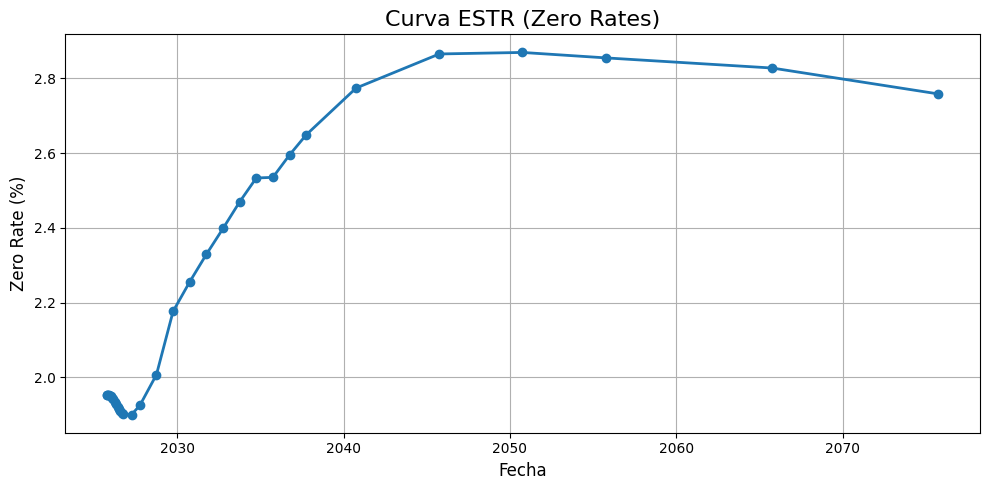

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Cargar CSV con separador ; ===
df = pd.read_csv('curvaESTR.csv', sep=';')

# === 2. Convertir columna de fecha ===
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# === 3. Graficar Zero Rate vs. Fecha ===
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Zero Rate'], marker='o', linewidth=2)

# === 4. Estética ===
plt.title("Curva ESTR (Zero Rates)", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Zero Rate (%)", fontsize=12)
plt.grid(True)
plt.tight_layout()

# === 5. Mostrar ===
plt.show()


### <font color=#336699>2. Valoración</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 En esta sección, valoraremos los bonos utilizando la curva. Para ello, crea una función (puedes hacerlo en un .py aparte) que con las **características del bono, la curva y un spread de crédito** devuelva la valoración del bono (incluyendo **precio limpio, cupón corrido y precio sucio**).

Si asumimos que el **spread de crédito es 0**, y la ejecutamos para el 01/10/2025...
- ¿Qué observas si comparas los precios obtenidos y los precios de mercado? 
- ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?
- ¿Qué otros factores influyen en ese spread?

Para la valoración, haz las siguientes simplificaciones:

- Asume que el vencimiento de los bonos perpetuos (para los que no hay vencimiento) es la próxima fecha call.
- Asume que todos aquellos bonos que tengan call serán calleados. Por lo tanto, usa la fecha call como fecha de vencimiento.
- Asume que los cupones son fijos hasta vencimiento (aunque alguno cambie a lo largo de la vida del bono).
- Usa la base de cálculo ACT/365. No tengas en cuenta la convención de día hábil.

Ten en cuenta que necesitarás una función de interpolación también. Interpola los factores de descuento exponencialmente.

</div>

In [10]:
# Establecemos la fecha
fecha_valor = datetime.datetime(2025,10,1)

In [11]:
# Se carga el universo.csv un formato Dataframe para facilitar el análisis de datos. 

df_universo = pd.read_csv("universo.csv", sep=";")


In [12]:
# Se carga el curvaESTR.csv un formato Dataframe para facilitar el análisis de datos. 

df_curvaESTR= pd.read_csv("curvaESTR.csv", sep=";")


In [13]:
# Programa central, calculo del precio de los bonos. 

import math
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pdsi 
import numpy as np


# =========================
#   FUNCIONES AUXILIARES
# =========================

def parse_date(date_str):
    """
    Convierte una fecha en formato DD/MM/YYYY a datetime.
    Devuelve None si la fecha es NaN.
    """
    if pd.isna(date_str):
        return None
    return datetime.strptime(str(date_str), "%d/%m/%Y")


def year_frac_act365(d1, d2):
    """
    Año fracción ACT/365.
    """
    return (d2 - d1).days / 365.0


# =========================
#   INTERPOLACIÓN CURVA
# =========================

def build_discount_interpolator(df_curva, valuation_date):
    """
    Construye una función de descuento D(t) a partir de df_curvaESTR,
    interpolando EXPONENCIALMENTE los factores de descuento.

    df_curva: DataFrame con columnas ["Date", "Discount"]
              Date en formato 'DD/MM/YYYY' (string).
    valuation_date: datetime de valoración.

    Devuelve: función df(t) que da el factor de descuento a plazo t (en años).
    """

    curva = df_curva.copy()

    # Pasamos Date a datetime y construimos tiempos en años desde valuation_date
    curva["Date_dt"] = curva["Date"].apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))
    curva["t"] = curva["Date_dt"].apply(lambda d: year_frac_act365(valuation_date, d))

    # Ordenamos por t
    curva = curva.sort_values("t").reset_index(drop=True)

    ts = curva["t"].values
    dfs = curva["Discount"].values

    def df_func(t):
        """
        Factor de descuento para un plazo t (en años),
        usando interpolación log-lineal de los factores de descuento:
        ln D(t) se interpola linealmente entre nodos.
        """
        # Antes del primer punto → usamos el primer DF
        if t <= ts[0]:
            return float(dfs[0])

        # Después del último punto → extrapolación usando el último tramo (flat en forward)
        if t >= ts[-1]:
            t1, t2 = ts[-2], ts[-1]
            d1, d2 = dfs[-2], dfs[-1]
            # tipo cero continuo entre t1 y t2
            r = (math.log(d2) - math.log(d1)) / (t2 - t1)
            # extendemos el último punto
            return float(d2 * math.exp(r * (t - t2)))

        # Interpolación entre dos nodos
        idx_next = np.searchsorted(ts, t, side="right")
        t1, t2 = ts[idx_next - 1], ts[idx_next]
        d1, d2 = dfs[idx_next - 1], dfs[idx_next]

        w = (t - t1) / (t2 - t1)
        lnD = math.log(d1) + w * (math.log(d2) - math.log(d1))
        return math.exp(lnD)

    return df_func


# =========================
#   GENERACIÓN DE FLUJOS
# =========================

def generate_cashflow_schedule(bond_row, valuation_date):
    """
    Genera el calendario de cupones FUTUROS (desde la fecha de valoración)
    siguiendo las simplificaciones del enunciado.

    - Si el bono es callable, se asume que será calleado: vencimiento = Next Call Date
    - Si es perpetuo (no hay Maturity), vencimiento = Next Call Date
    - ACT/365 para el conteo de días.
    - No se tiene en cuenta la convención de día hábil.
    """

    maturity = parse_date(bond_row["Maturity"])
    next_call = parse_date(bond_row["Next Call Date"])
    callable_flag = str(bond_row["Callable"]).strip().upper() == "Y"

    # Determinamos la fecha de “vencimiento efectivo”
    if callable_flag and next_call is not None:
        maturity_date = next_call
    elif maturity is not None:
        maturity_date = maturity
    elif next_call is not None:
        # Perpetuo → vencimiento en la próxima call
        maturity_date = next_call
    else:
        # No tenemos nada razonable
        return [], None

    freq = int(bond_row["Coupon Frequency"])  # nº de pagos de cupón al año

    # Construimos las fechas de cupón hacia atrás desde maturity_date hasta valuation_date
    dates = []
    d = maturity_date
    while d > valuation_date:
        dates.append(d)
        # retrocedemos un periodo de cupón (meses = 12/freq)
        d = d - relativedelta(months=int(12 / freq))

    dates = sorted(dates)  # del más cercano al más lejano
    last_coupon_before_val = d  # última fecha de cupón ≤ valuation_date

    return dates, last_coupon_before_val


# =========================
#   VALORACIÓN DEL BONO
# =========================

def price_bond(bond_row, df_curve_func, valuation_date,
               credit_spread=0.0, notional=100.0):
    """
    Valora un bono dado su registro en df_universo, la curva y un spread de crédito.

    Parámetros:
    - bond_row: fila (Series) de df_universo.
    - df_curve_func: función df(t) que da el factor de descuento libre de riesgo
                     a plazo t (años) → se obtiene con build_discount_interpolator.
    - valuation_date: datetime de valoración (p. ej. 01/10/2025).
    - credit_spread: spread de crédito en TÉRMINOS ANUALES Y CONTINUOS (por ejemplo,
                     0.01 = 1% = 100 pb). Se aplica como exp(-spread * t).
    - notional: nominal del bono (100 por defecto).

    Devuelve:
    (precio_limpio, cupon_corrido, precio_sucio)
    """

    coupon_rate_annual = float(bond_row["Coupon"]) / 100.0  # de % a tanto por uno
    freq = int(bond_row["Coupon Frequency"])

    # Fechas de pago de cupones y última fecha de cupón anterior a la valoración
    pay_dates, last_coupon_date = generate_cashflow_schedule(bond_row, valuation_date)

    if not pay_dates:
        return np.nan, np.nan, np.nan

    coupon_cf = notional * coupon_rate_annual / freq

    # Valor presente de los flujos futuros
    pv = 0.0
    for d in pay_dates:
        t = year_frac_act365(valuation_date, d)
        df_risk_free = df_curve_func(t)
        df_total = df_risk_free * math.exp(-credit_spread * t)  # añadimos spread de crédito

        cf = coupon_cf
        # En el último pago devolvemos también el nominal
        if d == pay_dates[-1]:
            cf += notional

        pv += cf * df_total

    # Cupón corrido (ACT/365)
    next_coupon_date = pay_dates[0]
    if last_coupon_date is None:
        accrued = 0.0
    else:
        # Fracción de periodo devengada
        full_period = year_frac_act365(last_coupon_date, next_coupon_date)
        accrual_fraction = year_frac_act365(last_coupon_date, valuation_date) / full_period
        accrued = coupon_cf * accrual_fraction

    precio_sucio = pv                # en % del nominal, porque notional=100
    precio_limpio = precio_sucio - accrued

    return precio_limpio, accrued, precio_sucio


# =========================
#   EJEMPLO DE USO
# =========================
if __name__ == "__main__":
    # Cargas que tú ya tienes en tu notebook:
    # df_universo = pd.read_csv("universo.csv", sep=";")
    # df_curvaESTR = pd.read_csv("curvaESTR.csv", sep=";")

    df_universo = pd.read_csv("universo.csv", sep=";")
    df_curvaESTR = pd.read_csv("curvaESTR.csv", sep=";")

    valuation_date = datetime.strptime("01/10/2025", "%d/%m/%Y")

    # Construimos la función de descuento a partir de la curva
    df_func = build_discount_interpolator(df_curvaESTR, valuation_date)

    # Valorar todos los bonos con spread de crédito = 0
    def valorar_fila(row):
        precio_limpio, cupon_corrido, precio_sucio = price_bond(
            row,
            df_func,
            valuation_date,
            credit_spread=0.0  # spread crédito = 0
        )
        return pd.Series({
            "Precio_teorico_limpio": precio_limpio,
            "Cupon_corrido": cupon_corrido,
            "Precio_teorico_sucio": precio_sucio
        })

    df_resultados = df_universo.join(df_universo.apply(valorar_fila, axis=1))

    # Por ejemplo, comparación con el precio de mercado de la hoja:
    df_resultados["Diferencia_teorico_mercado"] = (
        df_resultados["Precio_teorico_limpio"] - df_resultados["Price"]
    )

    # Puedes mirar algunas filas:
    print(df_resultados[[
        "ISIN", "Price", "Precio_teorico_limpio",
        "Cupon_corrido", "Precio_teorico_sucio",
        "Diferencia_teorico_mercado"
    ]].head())


           ISIN     Price  Precio_teorico_limpio  Cupon_corrido  \
0  XS0161488498  127.8353             133.757847       5.136986   
1  FR0000471930  131.3195             137.971025       5.476027   
2  XS0162513211  115.7800             122.217546       3.607534   
3  XS0162869076  116.3000             123.056925       3.685959   
4  FR0010014845  112.3887             125.363091       0.197260   

   Precio_teorico_sucio  Diferencia_teorico_mercado  
0            138.894833                    5.922547  
1            143.447053                    6.651525  
2            125.825080                    6.437546  
3            126.742884                    6.756925  
4            125.560351                   12.974391  


##### <font color=#CC6600>Respuesta a las preguntas planteadas</font>

- ¿Qué observas si comparas los precios obtenidos y los precios de mercado?


- ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?


- ¿Qué otros factores influyen en ese spread?

### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior. 
- ¿Qué observas? ¿Tienen sentido los resultados? 
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>

In [14]:
def calcular_z_spreads(df_universo, df_curva, valuation_date):
    """
    Calcula el z-spread de cada bono del universo, devolviendo:
      - df_resultados: DataFrame con columna "z_spread"
      - top5: los 5 z-spreads más altos
      - bottom5: los 5 z-spreads más bajos

    Requiere:
      - build_discount_interpolator()
      - price_bond()
      - parse_date(), year_frac_act365(), etc.
    """

    # 1. Construir función de descuento
    df_func = build_discount_interpolator(df_curva, valuation_date)

    # 2. Función para resolver spread por bisección
    def solve_z_spread(bond_row):
        market_price = bond_row["Price"]
        if pd.isna(market_price) or market_price <= 0:
            return np.nan

        # Rango plausible de spreads (-5% a +20% anual continuo)
        low, high = -0.05, 0.20

        for _ in range(60):  # suficiente para precisión <1e-8
            mid = (low + high) / 2
            model_price = price_bond(
                bond_row, df_func, valuation_date, credit_spread=mid
            )[0]  # precio limpio

            if model_price is None:
                return np.nan

            # Si el precio teórico > precio mercado → hace falta más spread
            if model_price > market_price:
                low = mid
            else:
                high = mid

        return mid

    # 3. Calcular z-spread por fila
    z_list = []
    for _, row in df_universo.iterrows():
        z = solve_z_spread(row)
        z_list.append(z*10000) # Multiplico por 10000 para que me lo de en puntos basicos

    df_universo = df_universo.copy()
    df_universo["z_spread"] = z_list

    # 4. Top y bottom
    top5 = df_universo.nlargest(5, "z_spread")[["ISIN", "z_spread"]]
    bottom5 = df_universo.nsmallest(5, "z_spread")[["ISIN", "z_spread"]]

    return df_universo, top5, bottom5


In [15]:
df_resultados, top5, bottom5 = calcular_z_spreads(
    df_universo,
    df_curvaESTR,
    datetime.strptime("01/10/2025", "%d/%m/%Y")
)

print("TOP 5 Z-SPREADS:")
print(top5)

print("\nBOTTOM 5 Z-SPREADS:")
print(bottom5)


TOP 5 Z-SPREADS:
              ISIN     z_spread
40    XS1186176571  1735.224700
1244  XS2367081523   633.818761
868   XS2193974701   332.359641
2106  XS2675884733   263.585414
1498  XS2342732646   251.557137

BOTTOM 5 Z-SPREADS:
              ISIN   z_spread
1729  XS2555196463   3.921708
14    DE000A1UDWN5   8.988384
386   XS1888184121   9.374861
72    FR0013073277  14.018093
84    XS1397134609  14.067322


##### <font color=#CC6600>Solución</font>

### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

In [21]:
# ============================================
# Backtest equiponderado SIN reinversión de cupones + CON rebalanceo mensual
# ============================================

import pandas as pd
import numpy as np
from datetime import datetime, date

# --------------------------------------------
# Helpers
# --------------------------------------------

def parse_ddmmyyyy(d):
    if pd.isna(d): return None
    if isinstance(d, (datetime, date)): 
        return d.date() if isinstance(d, datetime) else d
    return datetime.strptime(str(d), "%d/%m/%Y").date()

def generate_coupon_schedule_backwards(effective_maturity, freq, start_date):
    months = int(12 // freq)
    dates_list = []
    current = effective_maturity
    while current >= start_date:
        dates_list.append(current)
        y = current.year
        m = current.month - months
        d = current.day
        while m <= 0:
            m += 12
            y -= 1
        while True:
            try:
                current = date(y, m, d)
                break
            except ValueError:
                d -= 1
    return dates_list

# --------------------------------------------
# Cargar datos
# --------------------------------------------

df_universo = pd.read_csv("universo.csv", sep=";")
df_precios_univ = pd.read_csv("precios_historicos_universo.csv", sep=";")
df_varios = pd.read_csv("precios_historicos_varios.csv", sep=";")

# --------------------------------------------
# Información bonos
# --------------------------------------------

bonds = df_universo.copy()
bonds["IssueDate"] = bonds["Issue date"].apply(parse_ddmmyyyy)
bonds["MaturityDate"] = bonds["Maturity"].apply(parse_ddmmyyyy)
bonds["CallDate"] = bonds["Next Call Date"].apply(parse_ddmmyyyy)
bonds["EffectiveMaturity"] = bonds["CallDate"].combine_first(bonds["MaturityDate"])
bonds = bonds.set_index("ISIN")

# --------------------------------------------
# Matriz precios
# --------------------------------------------

df_precios_univ["ISIN"] = df_precios_univ["Unnamed: 0"].str.split().str[0]
date_cols = [c for c in df_precios_univ.columns if c not in ("Unnamed: 0", "ISIN")]

price_matrix = df_precios_univ.set_index("ISIN")[date_cols].replace("#N/D", np.nan)
price_matrix = price_matrix.apply(pd.to_numeric, errors="coerce")

prices = price_matrix.T
prices.index = pd.to_datetime(prices.index, format="%d/%m/%Y")
prices = prices.sort_index()
prices = prices[bonds.index]
prices_ffill = prices.ffill()

# --------------------------------------------
# Benchmark
# --------------------------------------------

df_varios["Date"] = pd.to_datetime(df_varios["Unnamed: 0"], format="%d/%m/%Y")
recm = df_varios.set_index("Date")["RECMTREU Index"].astype(float)

# Fechas comunes
trading_dates = prices_ffill.index.intersection(recm.index).sort_values()

# --------------------------------------------
# Matriz cupones
# --------------------------------------------

coupons = pd.DataFrame(0.0, index=trading_dates, columns=bonds.index)
start_window = trading_dates[0].date()
end_window = trading_dates[-1].date()
td_array = trading_dates.values

for isin, row in bonds.iterrows():
    freq = row["Coupon Frequency"]
    if pd.isna(freq) or freq == 0: continue
    freq = int(freq)

    coupon_rate_annual = float(row["Coupon"]) / 100.0
    coupon_payment = 100.0 * coupon_rate_annual / freq

    eff_mat = row["EffectiveMaturity"]
    if eff_mat is None or pd.isna(eff_mat): continue
    if eff_mat < start_window: continue

    schedule = generate_coupon_schedule_backwards(eff_mat, freq, start_window)
    for cp_date in schedule:
        if cp_date > end_window: continue
        ts = pd.Timestamp(cp_date)
        idx = td_array.searchsorted(ts.to_datetime64(), side="left")
        if idx >= len(td_array): continue
        pay_dt = trading_dates[idx]
        coupons.at[pay_dt, isin] += coupon_payment

# --------------------------------------------
# Bonos vivos
# --------------------------------------------

def alive_bonds_on(date_ts):
    d = date_ts.date()
    return (
        (bonds["IssueDate"] <= d) &
        (bonds["EffectiveMaturity"] > d)
    )

# --------------------------------------------
# Rebalanceo mensual
# --------------------------------------------

rebalance_dates = trading_dates.to_series().groupby([trading_dates.year, trading_dates.month]).min()
rebalance_set = set(rebalance_dates.values)

# --------------------------------------------
# Backtest SIN reinversión de cupones
# --------------------------------------------

initial_value = 100.0
cash = 0.0  # <<<<< ACUMULA cupón pero NO se reinvierte
portfolio_value = pd.Series(index=trading_dates, dtype=float)
holdings = pd.Series(0.0, index=bonds.index)

# Día inicial
t0 = trading_dates[0]
price_t0 = prices_ffill.loc[t0]

alive_mask_0 = alive_bonds_on(t0)
live_isins_0 = bonds.index[alive_mask_0]
live_prices_0 = price_t0[live_isins_0].dropna()

N0 = len(live_prices_0)
weights0 = np.repeat(1.0 / N0, N0)

holdings.loc[live_prices_0.index] = weights0 * initial_value / live_prices_0.values
portfolio_value[t0] = float((holdings * price_t0).sum()) + cash

# Resto días
for t in trading_dates[1:]:
    price_t = prices_ffill.loc[t]
    value_from_prices = float((holdings * price_t).sum())

    # NO reinversión → los cupones se acumulan en cash
    cash += float((holdings * coupons.loc[t]).sum())

    total_value = value_from_prices + cash
    portfolio_value[t] = total_value

    # Rebanceo mensual
    if t in rebalance_set:
        alive_mask = alive_bonds_on(t)
        live_isins = bonds.index[alive_mask]
        live_prices = price_t[live_isins].dropna()

        if len(live_prices) > 0:
            N = len(live_prices)
            weights = np.repeat(1.0 / N, N)

            # SOLO se invierte el valor de la cartera EN BONOS, no el cash
            investable_value = value_from_prices

            new_holdings = pd.Series(0.0, index=bonds.index)
            new_holdings.loc[live_prices.index] = (
                weights * investable_value / live_prices.values
            )
            holdings = new_holdings

# --------------------------------------------
# Índices
# --------------------------------------------

portfolio_index = portfolio_value / portfolio_value.iloc[0] * 100.0
recm_common = recm.loc[trading_dates]
benchmark_index = recm_common / recm_common.iloc[0] * 100.0

df_cartera_vs_benchmark = pd.DataFrame({
    "Date": trading_dates,
    "PortfolioValue": portfolio_value.values,
    "RECMTREU": recm_common.values,
    "PortfolioIndex": portfolio_index.values,
    "BenchmarkIndex": benchmark_index.values
})


C:\Users\Fernando Dapena T\AppData\Local\Temp\ipykernel_25476\1379441462.py:44: DtypeWarning: Columns (2,3,4,5,6,9,10,11,12,13,16,17,18,19,20,23,24,25,26,27,30,31,32,33,34,37,38,39,40,41,44,45,46,47,48,51,52,53,54,55,58,59,60,61,62,65,66,67,68,75,89,90,185,219,240,248,275,319,331,415,454,458,473,563,564,565,571,572,573,576,577,578,580,583,604,695) have mixed types. Specify dtype option on import or set low_memory=False.
  df_precios_univ = pd.read_csv("precios_historicos_universo.csv", sep=";")
C:\Users\Fernando Dapena T\AppData\Local\Temp\ipykernel_25476\1379441462.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_matrix = df_precios_univ.set_index("ISIN")[date_cols].replace("#N/D", np.nan)


### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID? Bis/Ask
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

In [1]:
# ============================================
# Backtest equiponderado SIN reinversión de cupones + CON rebalanceo mensual
# ============================================

import pandas as pd
import numpy as np
from datetime import datetime, date

# --------------------------------------------
# Helpers
# --------------------------------------------

def parse_ddmmyyyy(d):
    if pd.isna(d): return None
    if isinstance(d, (datetime, date)): 
        return d.date() if isinstance(d, datetime) else d
    return datetime.strptime(str(d), "%d/%m/%Y").date()

def generate_coupon_schedule_backwards(effective_maturity, freq, start_date):
    months = int(12 // freq)
    dates_list = []
    current = effective_maturity
    while current >= start_date:
        dates_list.append(current)
        y = current.year
        m = current.month - months
        d = current.day
        while m <= 0:
            m += 12
            y -= 1
        while True:
            try:
                current = date(y, m, d)
                break
            except ValueError:
                d -= 1
    return dates_list

# --------------------------------------------
# Cargar datos
# --------------------------------------------

df_universo = pd.read_csv("universo.csv", sep=";")
df_precios_univ = pd.read_csv("precios_historicos_universo.csv", sep=";")
df_varios = pd.read_csv("precios_historicos_varios.csv", sep=";")

# --------------------------------------------
# Información bonos
# --------------------------------------------

bonds = df_universo.copy()
bonds["IssueDate"] = bonds["Issue date"].apply(parse_ddmmyyyy)
bonds["MaturityDate"] = bonds["Maturity"].apply(parse_ddmmyyyy)
bonds["CallDate"] = bonds["Next Call Date"].apply(parse_ddmmyyyy)
bonds["EffectiveMaturity"] = bonds["CallDate"].combine_first(bonds["MaturityDate"])
bonds = bonds.set_index("ISIN")

# --------------------------------------------
# Matriz precios
# --------------------------------------------

df_precios_univ["ISIN"] = df_precios_univ["Unnamed: 0"].str.split().str[0]
date_cols = [c for c in df_precios_univ.columns if c not in ("Unnamed: 0", "ISIN")]

price_matrix = df_precios_univ.set_index("ISIN")[date_cols].replace("#N/D", np.nan)
price_matrix = price_matrix.apply(pd.to_numeric, errors="coerce")

prices = price_matrix.T
prices.index = pd.to_datetime(prices.index, format="%d/%m/%Y")
prices = prices.sort_index()
prices = prices[bonds.index]
prices_ffill = prices.ffill()

# --------------------------------------------
# Benchmark
# --------------------------------------------

df_varios["Date"] = pd.to_datetime(df_varios["Unnamed: 0"], format="%d/%m/%Y")
recm = df_varios.set_index("Date")["RECMTREU Index"].astype(float)

# Fechas comunes
trading_dates = prices_ffill.index.intersection(recm.index).sort_values()

# --------------------------------------------
# Matriz cupones
# --------------------------------------------

coupons = pd.DataFrame(0.0, index=trading_dates, columns=bonds.index)
start_window = trading_dates[0].date()
end_window = trading_dates[-1].date()
td_array = trading_dates.values

for isin, row in bonds.iterrows():
    freq = row["Coupon Frequency"]
    if pd.isna(freq) or freq == 0: continue
    freq = int(freq)

    coupon_rate_annual = float(row["Coupon"]) / 100.0
    coupon_payment = 100.0 * coupon_rate_annual / freq

    eff_mat = row["EffectiveMaturity"]
    if eff_mat is None or pd.isna(eff_mat): continue
    if eff_mat < start_window: continue

    schedule = generate_coupon_schedule_backwards(eff_mat, freq, start_window)
    for cp_date in schedule:
        if cp_date > end_window: continue
        ts = pd.Timestamp(cp_date)
        idx = td_array.searchsorted(ts.to_datetime64(), side="left")
        if idx >= len(td_array): continue
        pay_dt = trading_dates[idx]
        coupons.at[pay_dt, isin] += coupon_payment

# --------------------------------------------
# Bonos vivos
# --------------------------------------------

def alive_bonds_on(date_ts):
    d = date_ts.date()
    return (
        (bonds["IssueDate"] <= d) &
        (bonds["EffectiveMaturity"] > d)
    )

# --------------------------------------------
# Rebalanceo mensual
# --------------------------------------------

rebalance_dates = trading_dates.to_series().groupby([trading_dates.year, trading_dates.month]).min()
rebalance_set = set(rebalance_dates.values)

# --------------------------------------------
# Backtest SIN reinversión de cupones
# --------------------------------------------

initial_value = 100.0
cash = 0.0  # <<<<< ACUMULA cupón pero NO se reinvierte
portfolio_value = pd.Series(index=trading_dates, dtype=float)
holdings = pd.Series(0.0, index=bonds.index)

# Día inicial
t0 = trading_dates[0]
price_t0 = prices_ffill.loc[t0]

alive_mask_0 = alive_bonds_on(t0)
live_isins_0 = bonds.index[alive_mask_0]
live_prices_0 = price_t0[live_isins_0].dropna()

N0 = len(live_prices_0)
weights0 = np.repeat(1.0 / N0, N0)

holdings.loc[live_prices_0.index] = weights0 * initial_value / live_prices_0.values
portfolio_value[t0] = float((holdings * price_t0).sum()) + cash

# Resto días
for t in trading_dates[1:]:
    price_t = prices_ffill.loc[t]
    value_from_prices = float((holdings * price_t).sum())

    # NO reinversión → los cupones se acumulan en cash
    cash += float((holdings * coupons.loc[t]).sum())

    total_value = value_from_prices + cash
    portfolio_value[t] = total_value

    # Rebanceo mensual
    if t in rebalance_set:
        alive_mask = alive_bonds_on(t)
        live_isins = bonds.index[alive_mask]
        live_prices = price_t[live_isins].dropna()

        if len(live_prices) > 0:
            N = len(live_prices)
            weights = np.repeat(1.0 / N, N)

            # SOLO se invierte el valor de la cartera EN BONOS, no el cash
            investable_value = value_from_prices

            new_holdings = pd.Series(0.0, index=bonds.index)
            new_holdings.loc[live_prices.index] = (
                weights * investable_value / live_prices.values
            )
            holdings = new_holdings

# --------------------------------------------
# Índices
# --------------------------------------------

portfolio_index = portfolio_value / portfolio_value.iloc[0] * 100.0
recm_common = recm.loc[trading_dates]
benchmark_index = recm_common / recm_common.iloc[0] * 100.0

df_cartera_vs_benchmark = pd.DataFrame({
    "Date": trading_dates,
    "PortfolioValue": portfolio_value.values,
    "RECMTREU": recm_common.values,
    "PortfolioIndex": portfolio_index.values,
    "BenchmarkIndex": benchmark_index.values
})


C:\Users\Fernando Dapena T\AppData\Local\Temp\ipykernel_19124\1379441462.py:44: DtypeWarning: Columns (2,3,4,5,6,9,10,11,12,13,16,17,18,19,20,23,24,25,26,27,30,31,32,33,34,37,38,39,40,41,44,45,46,47,48,51,52,53,54,55,58,59,60,61,62,65,66,67,68,75,89,90,185,219,240,248,275,319,331,415,454,458,473,563,564,565,571,572,573,576,577,578,580,583,604,695) have mixed types. Specify dtype option on import or set low_memory=False.
  df_precios_univ = pd.read_csv("precios_historicos_universo.csv", sep=";")
C:\Users\Fernando Dapena T\AppData\Local\Temp\ipykernel_19124\1379441462.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_matrix = df_precios_univ.set_index("ISIN")[date_cols].replace("#N/D", np.nan)


In [3]:
# ============================================
# Rentabilidades acumuladas (Price Return / Total Return)
# ============================================

valor_ini_cartera = df_cartera_vs_benchmark["PortfolioValue"].iloc[0]
valor_fin_cartera = df_cartera_vs_benchmark["PortfolioValue"].iloc[-1]

valor_ini_bench = df_cartera_vs_benchmark["RECMTREU"].iloc[0]
valor_fin_bench = df_cartera_vs_benchmark["RECMTREU"].iloc[-1]

rentabilidad_cartera = (valor_fin_cartera / valor_ini_cartera - 1) * 100
rentabilidad_bench = (valor_fin_bench / valor_ini_bench - 1) * 100

print(f"Rentabilidad Acumulada Cartera (Price Return): {rentabilidad_cartera:.2f}%")
print(f"Rentabilidad Acumulada Benchmark (Total Return): {rentabilidad_bench:.2f}%")


Rentabilidad Acumulada Cartera (Price Return): 15.32%
Rentabilidad Acumulada Benchmark (Total Return): 13.87%


### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

Mi cartera la componene los siguientes bonos: <font color=#CC3333>XS2698603326, XS2623496085, IT0005549479, XS2555420103, FR001400J861, FR001400M2F4, XS2553801502, XS2592650373, XS2554746185, XS2577572188, XS2586123965, XS0300113254, XS2576362839, FR001400IEQ0, FR001400CRG6, XS2708354811, XS2597999452, XS2597113989, XS2548080832, FR001400L4V8.</font>

Estos han sido seleccionados teniendo en cuenta las condiciones que se le pedía a la cartera y su YTM, intentando que esta fuera lo más alta posible mara máximizar la rentabilidad. Ninguno de ellos tiene una duración mayor a 3 años por lo que la cartera tampoco la tendrá y solo he incluido 2 bonos HY que son los del mismo emisor, Ford Motor Credit.

A continuación muestro el código que calcula la rentabilidad de la cartera: 

In [19]:
# ============================================
# Backtest con 1000 ponderaciones aleatorias
# ============================================

import pandas as pd
import numpy as np
from datetime import datetime, date

# --------------------------------------------
# 1. Helpers
# --------------------------------------------

def parse_ddmmyyyy(d):
    if pd.isna(d):
        return None
    if isinstance(d, (datetime, date)):
        return d.date() if isinstance(d, datetime) else d
    return datetime.strptime(str(d), "%d/%m/%Y").date()

def generate_coupon_schedule_backwards(effective_maturity, freq, start_date):
    months = int(12 // freq)
    dates_list = []
    current = effective_maturity

    while current >= start_date:
        dates_list.append(current)
        y = current.year
        m = current.month - months
        d = current.day

        while m <= 0:
            m += 12
            y -= 1

        while True:
            try:
                current = date(y, m, d)
                break
            except ValueError:
                d -= 1

    return dates_list

# --------------------------------------------
# 2. Carga Datos
# --------------------------------------------

df_universo = pd.read_csv("universo_mod_limpieza_carte.csv", sep=";")
df_precios_univ = pd.read_csv("precios_historicos_universo_mod_cartera_mia.csv", sep=";")

# --------------------------------------------
# 3. Información de bonos
# --------------------------------------------

bonds = df_universo.copy()
bonds["IssueDate"] = bonds["Issue date"].apply(parse_ddmmyyyy)
bonds["MaturityDate"] = bonds["Maturity"].apply(parse_ddmmyyyy)
bonds["CallDate"] = bonds["Next Call Date"].apply(parse_ddmmyyyy)
bonds["EffectiveMaturity"] = bonds["CallDate"].combine_first(bonds["MaturityDate"])
bonds = bonds.set_index("ISIN")

# --------------------------------------------
# 4. Matriz de precios
# --------------------------------------------

df_precios_univ["ISIN"] = df_precios_univ["Unnamed: 0"].str.split().str[0]
date_cols = [c for c in df_precios_univ.columns if c not in ("Unnamed: 0", "ISIN")]

price_matrix = df_precios_univ.set_index("ISIN")[date_cols].replace("#N/D", np.nan)
price_matrix = price_matrix.apply(pd.to_numeric, errors="coerce")

prices = price_matrix.T
prices.index = pd.to_datetime(prices.index, format="%d/%m/%Y")
prices = prices.sort_index()

prices = prices.replace(0, np.nan)
prices = prices[bonds.index]
prices_ffill = prices.ffill()

# Nueva lógica: empezar en el primer día con datos
valid_first_day = prices_ffill.dropna(how="all").index[0]
prices_ffill = prices_ffill.loc[valid_first_day:]
trading_dates = prices_ffill.index

# --------------------------------------------
# 5. Generación de cupones
# --------------------------------------------

coupons = pd.DataFrame(0.0, index=trading_dates, columns=bonds.index)

start_window = trading_dates[0].date()
end_window = trading_dates[-1].date()
td_array = trading_dates.values

for isin, row in bonds.iterrows():
    freq = row["Coupon Frequency"]
    if pd.isna(freq) or freq == 0:
        continue
    freq = int(freq)

    coupon_rate_annual = float(row["Coupon"]) / 100.0
    coupon_payment = 100.0 * coupon_rate_annual / freq

    eff_mat = row["EffectiveMaturity"]
    if eff_mat is None or pd.isna(eff_mat):
        continue
    if eff_mat < start_window:
        continue

    schedule = generate_coupon_schedule_backwards(eff_mat, freq, start_window)

    for cp_date in schedule:
        if cp_date > end_window:
            continue
        ts = pd.Timestamp(cp_date)
        idx = td_array.searchsorted(ts.to_datetime64(), side="left")
        if idx < len(td_array):
            pay_dt = trading_dates[idx]
            coupons.at[pay_dt, isin] += coupon_payment

# --------------------------------------------
# 6. Función: Bonos vivos
# --------------------------------------------

def alive_bonds_on(date_ts):
    d = date_ts.date()
    alive_mask = (
        bonds["IssueDate"].notna() &
        bonds["EffectiveMaturity"].notna() &
        (bonds["IssueDate"] <= d) &
        (bonds["EffectiveMaturity"] > d)
    )
    return alive_mask

# --------------------------------------------
# 7. Backtest con un vector de pesos (BUY & HOLD)
# --------------------------------------------

def run_backtest_with_weights(weight_vector):

    holdings = pd.Series(0.0, index=bonds.index)

    t0 = trading_dates[0]
    price_t0 = prices_ffill.loc[t0]

    alive_mask_0 = alive_bonds_on(t0)
    live_isins_0 = bonds.index[alive_mask_0]

    price_live_0 = price_t0[live_isins_0].dropna()
    price_live_0 = price_live_0[price_live_0 > 0]

    valid_isins = price_live_0.index

    weights_adj = weight_vector.reindex(bonds.index).fillna(0)
    weights_adj = weights_adj.loc[valid_isins]
    weights_adj = weights_adj / weights_adj.sum()

    holdings.loc[valid_isins] = weights_adj * 100.0 / price_live_0.values

    pv = pd.Series(index=trading_dates, dtype=float)
    pv[t0] = float((holdings * price_t0).sum())

    # BUY AND HOLD
    h = holdings.copy()

    for t in trading_dates[1:]:
        price_t = prices_ffill.loc[t]
        value_from_prices = float((h * price_t).sum())
        coupon_cash = float((h * coupons.loc[t]).sum())
        pv[t] = value_from_prices + coupon_cash

    final_return = pv.iloc[-1] / pv.iloc[0] - 1
    return final_return, pv.iloc[-1], pv

# --------------------------------------------
# 8. Monte Carlo — 1000 portfolios aleatorios
# --------------------------------------------

fixed_weights = {
    "XS2623496085": 0.05,
    "XS2586123965": 0.05
}

W_fixed_total = 0.10
W_random_total = 0.90

all_isins = bonds.index.tolist()
free_isins = [i for i in all_isins if i not in fixed_weights.keys()]

results = []

for k in range(2000):
    random_vec = np.random.rand(len(free_isins))
    random_vec = random_vec / random_vec.sum() * W_random_total

    weights = pd.Series(0.0, index=all_isins)

    for isin, w in fixed_weights.items():
        weights[isin] = w

    weights.loc[free_isins] = random_vec

    ret, final_value, _ = run_backtest_with_weights(weights)

    results.append({
        "iter": k,
        "return": ret,
        "final_value": final_value,
        **weights.to_dict()
    })

df_random_tests = pd.DataFrame(results)

# --------------------------------------------
# 9. Mostrar el mejor portfolio
# --------------------------------------------

best = df_random_tests.loc[df_random_tests["return"].idxmax()]

print("\n==============================")
print("       MEJOR PORTFOLIO")
print("==============================\n")

print("Rentabilidad máxima: {:.2f}%".format(best["return"] * 100))
print("Valor final:", best["final_value"])

print("\nPesos óptimos:")
print(best[all_isins])


C:\Users\Fernando Dapena T\AppData\Local\Temp\ipykernel_25476\1996541044.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_matrix = df_precios_univ.set_index("ISIN")[date_cols].replace("#N/D", np.nan)



       MEJOR PORTFOLIO

Rentabilidad máxima: 4.27%
Valor final: 104.27458554843903

Pesos óptimos:
XS2698603326    0.014275
XS2623496085    0.050000
IT0005549479    0.102876
XS2555420103    0.002165
FR001400J861    0.111228
FR001400M2F4    0.001882
XS2553801502    0.083547
XS2592650373    0.088229
XS2554746185    0.015393
XS2577572188    0.023836
XS2586123965    0.050000
XS0300113254    0.039654
XS2576362839    0.024472
FR001400IEQ0    0.103563
FR001400CRG6    0.087646
XS2708354811    0.002559
XS2597999452    0.101116
XS2597113989    0.015884
XS2548080832    0.002979
FR001400L4V8    0.078698
Name: 433, dtype: float64


##### <font color=#CC6600>Riesgo de crédito</font>

##### <font color=#CC6600>Riesgo de liquidez</font>

##### <font color=#CC6600>Backtest</font>

##### <font color=#CC6600>Modified Duration</font>

In [20]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
from dateutil.relativedelta import relativedelta


# ====================================================
#   UTILIDADES
# ====================================================

def parse_date(date_str):
    if pd.isna(date_str):
        return None
    return datetime.strptime(str(date_str), "%d/%m/%Y")

def year_frac_act365(d1, d2):
    return (d2 - d1).days / 365.0


# ====================================================
#   CURVA DE DESCUENTO
# ====================================================

def build_discount_interpolator(df_curva, valuation_date):
    curva = df_curva.copy()
    curva["Date_dt"] = curva["Date"].apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))
    curva["t"] = curva["Date_dt"].apply(lambda d: year_frac_act365(valuation_date, d))

    curva = curva.sort_values("t").reset_index(drop=True)
    ts = curva["t"].values
    dfs = curva["Discount"].values

    def df_func(t):
        if t <= ts[0]:
            return dfs[0]
        if t >= ts[-1]:
            t1, t2 = ts[-2], ts[-1]
            d1, d2 = dfs[-2], dfs[-1]
            r = (math.log(d2) - math.log(d1)) / (t2 - t1)
            return d2 * math.exp(r * (t - t2))

        idx = np.searchsorted(ts, t, side="right")
        t1, t2 = ts[idx - 1], ts[idx]
        d1, d2 = dfs[idx - 1], dfs[idx]

        w = (t - t1) / (t2 - t1)
        lnD = math.log(d1) + w * (math.log(d2) - math.log(d1))
        return math.exp(lnD)

    return df_func


# ====================================================
#   GENERACIÓN DE FLUJOS DEL BONO
# ====================================================

def generate_cashflow_schedule(bond_row, valuation_date):
    maturity = parse_date(bond_row["Maturity"])
    next_call = parse_date(bond_row["Next Call Date"])
    callable_flag = str(bond_row["Callable"]).strip().upper() == "Y"

    if callable_flag and next_call is not None:
        maturity_date = next_call
    elif maturity is not None:
        maturity_date = maturity
    elif next_call is not None:
        maturity_date = next_call
    else:
        return [], None

    freq = int(bond_row["Coupon Frequency"])

    dates = []
    d = maturity_date
    while d > valuation_date:
        dates.append(d)
        d = d - relativedelta(months=int(12 / freq))

    dates = sorted(dates)
    last_coupon_before_val = d
    return dates, last_coupon_before_val


# ====================================================
#   VALORACIÓN DEL BONO (precio sucio)
# ====================================================

def price_bond(bond_row, df_func, valuation_date,
               credit_spread=0.0, notional=100.0):

    coupon_rate = float(bond_row["Coupon"]) / 100.0
    freq = int(bond_row["Coupon Frequency"])
    coupon_cf = notional * coupon_rate / freq

    pay_dates, _ = generate_cashflow_schedule(bond_row, valuation_date)
    if not pay_dates:
        return np.nan

    pv = 0.0
    for d in pay_dates:
        t = year_frac_act365(valuation_date, d)
        df = df_func(t) * math.exp(-credit_spread * t)

        cf = coupon_cf
        if d == pay_dates[-1]:
            cf += notional

        pv += cf * df

    return pv


# ====================================================
#   DURACIÓN Y CONVEXIDAD
# ====================================================

def duration_convexity(bond_row, df_func, valuation_date,
                       credit_spread=0.0, notional=100.0, dy=1e-4):

    coupon_rate = float(bond_row["Coupon"]) / 100.0
    freq = int(bond_row["Coupon Frequency"])
    coupon_cf = notional * coupon_rate / freq

    pay_dates, _ = generate_cashflow_schedule(bond_row, valuation_date)
    if not pay_dates:
        return np.nan, np.nan, np.nan, np.nan

    P0 = price_bond(bond_row, df_func, valuation_date, credit_spread, notional)

    num_D = 0.0
    num_C = 0.0

    for d in pay_dates:
        t = year_frac_act365(valuation_date, d)
        df = df_func(t) * math.exp(-credit_spread * t)

        cf = coupon_cf
        if d == pay_dates[-1]:
            cf += notional

        pv = cf * df
        num_D += t * pv
        num_C += (t**2) * pv

    D_mod = num_D / P0
    Conv = num_C / P0

    P_up = price_bond(bond_row, df_func, valuation_date, credit_spread + dy, notional)
    P_down = price_bond(bond_row, df_func, valuation_date, credit_spread - dy, notional)

    D_eff = (P_down - P_up) / (2 * P0 * dy)
    Conv_eff = (P_down + P_up - 2 * P0) / (P0 * dy**2)

    return D_mod, Conv, D_eff, Conv_eff


# ====================================================
#   PROCESAR TODOS LOS BONOS
# ====================================================

def calcular_duracion_convexidad_universo(df_universo, df_curva, valuation_date_str="01/10/2025"):

    valuation_date = datetime.strptime(valuation_date_str, "%d/%m/%Y")
    df_func = build_discount_interpolator(df_curva, valuation_date)

    Dmods = []
    Convs = []
    D_effs = []
    C_effs = []

    for _, row in df_universo.iterrows():
        D_mod, Conv, D_eff, C_eff = duration_convexity(
            row, df_func, valuation_date
        )
        Dmods.append(D_mod)
        Convs.append(Conv)
        D_effs.append(D_eff)
        C_effs.append(C_eff)

    df_res = df_universo.copy()
    df_res["Duración_modificada"] = Dmods
    df_res["Convexidad"] = Convs
    df_res["Duración_efectiva"] = D_effs
    df_res["Convexidad_efectiva"] = C_effs

    return df_res


# ====================================================
#   EJECUCIÓN
# ====================================================

if __name__ == "__main__":

    df_universo = pd.read_csv("universo_mod_limpieza_carte.csv", sep=";")
    df_curva = pd.read_csv("curvaESTR.csv", sep=";")

    df_res = calcular_duracion_convexidad_universo(df_universo, df_curva)

    print(df_res[[
        "ISIN",
        "Duración_modificada",
        "Convexidad",
        "Duración_efectiva",
        "Convexidad_efectiva"
    ]])


            ISIN  Duración_modificada  Convexidad  Duración_efectiva  \
0   XS2698603326             0.955404    0.965266           0.955404   
1   XS2623496085             2.461579    6.301959           2.461579   
2   IT0005549479             1.646823    2.763599           1.646823   
3   XS2555420103             1.069967    1.195307           1.069967   
4   FR001400J861             2.407014    6.021043           2.407014   
5   FR001400M2F4             2.752453    7.791643           2.752453   
6   XS2553801502             1.972296    4.100500           1.972296   
7   XS2592650373             1.386598    1.966791           1.386598   
8   XS2554746185             1.075318    1.199493           1.075318   
9   XS2577572188             1.253403    1.614201           1.253403   
10  XS2586123965             1.793180    3.258631           1.793180   
11  XS0300113254             1.562989    2.486119           1.562989   
12  XS2576362839             1.743801    3.084034           1.74

### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros?
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?

</div>

### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>